In [177]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import pyspark.pandas as ps
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
notebooks_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebooks_dir, os.pardir))
processed_data_path = f"{project_root}/data/processed_data_lmer.pkl"


# Add the project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from utils.model_utils import train, predict, evaluate, inverse_normalize
    from utils.process_data import get_processed_data, prepare_datasets, transform_one_hot_to_numeric
    from models.predictor_simple_cnn import SimpleCNN
    from models.combined_model_1 import CombinedModel1
    from datasets.combined_dataset import CombinedDataset
    from utils.parameter_tuning import random_search
    from utils.plots import plot_losses, plot_predictions_vs_labels, plot_predictions_vs_labels_by_species\
    , plot_boxplot_predictions_vs_labels, plot_hexbin_predictions_vs_labels, plot_histogram
    print("Import successful")
except ImportError as e:
    print(f"Error importing module: {e}")


if os.path.exists(processed_data_path):
    data_df = pd.read_pickle(processed_data_path)
else:
   data_df = get_processed_data(project_root) 

data_df = transform_dataframe(data_df, False)

Import successful


In [179]:
data_df.rename(columns={"stress_name": 'condition', 'stress': 'tpm'}, inplace=True)
data_df.head()



,species,upstream200,CCT,CTT,TTC,TCC,CCA,CAA,AAG,AGC,...,CAK,AKT,KTC,AAN,ANG,TTR,TRG,RGA,tpm,condition
0,0,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",3.0,7.0,9.0,7.0,8.0,6.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.026784,0
1,0,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",3.0,7.0,9.0,7.0,8.0,6.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.617587,6
2,0,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",3.0,7.0,9.0,7.0,8.0,6.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.445845,5
3,0,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",3.0,7.0,9.0,7.0,8.0,6.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922333,8
4,0,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",3.0,7.0,9.0,7.0,8.0,6.0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013922,1


In [187]:
# Separate features and target
X = data_df.drop(columns=['tpm'])
y = data_df['tpm']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


# Reset the indices of the DataFrames
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Split X into tabular and sequence data
X_train_tabular = X_train.drop(columns=['upstream200'])
X_val_tabular = X_val.drop(columns=['upstream200'])
X_test_tabular = X_test.drop(columns=['upstream200'])

X_train_sequence = np.array(X_train['upstream200'].to_list())
X_test_sequence = np.array(X_test['upstream200'].to_list())
X_val_sequence = np.array(X_val['upstream200'].to_list())

# Convert to PyTorch tensors
X_train_sequence = torch.tensor(X_train_sequence, dtype=torch.float32)
X_test_sequence = torch.tensor(X_test_sequence, dtype=torch.float32)
X_val_sequence = torch.tensor(X_val_sequence, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)



In [198]:
X_train

,species,upstream200,CCT,CTT,TTC,TCC,CCA,CAA,AAG,AGC,...,KCA,CAK,AKT,KTC,AAN,ANG,TTR,TRG,RGA,condition
0,27,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0,...",1.0,1.0,2.0,3.0,3.0,7.0,10.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,3,"[[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",1.0,6.0,3.0,0.0,0.0,4.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,21,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",2.0,1.0,5.0,2.0,3.0,2.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,13,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",5.0,2.0,3.0,3.0,2.0,5.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,13,"[[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1], [1,...",2.0,4.0,6.0,1.0,1.0,5.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699888,7,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...",2.0,2.0,3.0,2.0,0.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
699889,7,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1,...",4.0,3.0,7.0,6.0,3.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
699890,15,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0,...",0.0,3.0,4.0,2.0,5.0,9.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
699891,6,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0,...",2.0,3.0,3.0,1.0,1.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [188]:
batch_size=128
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_sequence, y_train_tensor)
val_dataset = TensorDataset(X_val_sequence, y_val_tensor)
test_dataset = TensorDataset(X_test_sequence, y_test_tensor)

# Dataloaders for cnn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [189]:
X_train_tabular

,species,CCT,CTT,TTC,TCC,CCA,CAA,AAG,AGC,GCT,...,KCA,CAK,AKT,KTC,AAN,ANG,TTR,TRG,RGA,condition
0,27,1.0,1.0,2.0,3.0,3.0,7.0,10.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,3,1.0,6.0,3.0,0.0,0.0,4.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,21,2.0,1.0,5.0,2.0,3.0,2.0,3.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,13,5.0,2.0,3.0,3.0,2.0,5.0,5.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,13,2.0,4.0,6.0,1.0,1.0,5.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699888,7,2.0,2.0,3.0,2.0,0.0,1.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
699889,7,4.0,3.0,7.0,6.0,3.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
699890,15,0.0,3.0,4.0,2.0,5.0,9.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
699891,6,2.0,3.0,3.0,1.0,1.0,2.0,2.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


# vanilla xgboost

In [190]:

# Train the XGBoost model on tabular data
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_tabular, y_train)

# Get predictions from the XGBoost model
xgb_train_preds = xgb_model.predict(X_train_tabular)
xgb_test_preds = xgb_model.predict(X_test_tabular)

In [191]:
mse = mean_squared_error(y_test,xgb_test_preds)
r2 = r2_score(y_test, xgb_test_preds)
print(f"mse: {mse:.4f}")
print(f"r2: {r2:.4f}")

mse: 0.6597
r2: 0.1470


# cnn

In [194]:
# Parameters
num_features = 4  
cnn_filters = 16
hidden_size = 64
seq_length = 203
kernel_size = 6
# Initialize and train the CNN model
cnn_model = SimpleCNN(num_features, cnn_filters, hidden_size, seq_length, kernel_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # Validation loss calculation
    combined_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



Epoch 1/5, Train Loss: 0.16946331547293758, Validation Loss: 0.7132112251006459
Epoch 2/5, Train Loss: 0.15024068047432101, Validation Loss: 0.6699816117945471
Epoch 3/5, Train Loss: 0.13997842398197816, Validation Loss: 0.6538497241409985
Epoch 4/5, Train Loss: 0.13481522490998646, Validation Loss: 0.6416286161953682
Epoch 5/5, Train Loss: 0.1315968418175787, Validation Loss: 0.6358106711781338


In [195]:
def evaluate_cnn_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')  # Change to 'cuda' if you are using GPU

            outputs = model(inputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    # Calculate R-squared
    r2 = r2_score(all_labels, all_preds)
    return r2

In [196]:
r2 = evaluate_cnn_model(cnn_model, test_loader)
print(f'R-squared for CNN model: {r2}')

R-squared for CNN model: 0.1824357913334339


In [199]:
# Save the models
# Save the XGBoost model
xgb_model.save_model('xgb_model_0147.json')

# Save the CNN model
torch.save(cnn_model.state_dict(), 'cnn_model_0182.pth')



# Combined Model

In [200]:


train_combined_dataset = CombinedDataset(X_train_tabular, X_train_sequence, y_train_tensor)
test_combined_dataset = CombinedDataset(X_test_tabular, X_test_sequence, y_test_tensor)
train_combined_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
test_combined_loader = DataLoader(test_combined_dataset, batch_size=32)

# Initialize the combined model
column_names = X_train_tabular.columns.tolist()
combined_model = CombinedModel(xgb_model, cnn_model, hidden_size, column_names)
# combined_model.to('cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

In [147]:
train_combined_dataset[0]

(tensor([ 9.,  1.,  4.,  1.,  0.,  1.,  4.,  4.,  4.,  5., 10.,  3.,  1.,  0.,
          1.,  2.,  3.,  1.,  5.,  9.,  0.,  3.,  6.,  0.,  3.,  2.,  1.,  0.,
          1.,  2.,  4.,  2.,  5.,  2.,  1.,  1.,  4.,  4.,  1.,  6.,  4.,  5.,
          1.,  9.,  5.,  5.,  8.,  6.,  2.,  1.,  0.,  0.,  1.,  6.,  6.,  2.,
         13.,  0.,  1.,  2.,  2.,  1.,  6.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 

In [143]:
X_train_tabular

,species,CCT,CTT,TTC,TCC,CCA,CAA,AAG,AGC,GCT,...,KCA,CAK,AKT,KTC,AAN,ANG,TTR,TRG,RGA,condition
0,9,1.0,4.0,1.0,0.0,1.0,4.0,4.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
1,10,1.0,4.0,2.0,1.0,2.0,4.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,4,2.0,2.0,3.0,1.0,1.0,1.0,5.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,13,3.0,5.0,7.0,5.0,3.0,3.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,4,0.0,2.0,5.0,4.0,2.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777654,7,3.0,4.0,3.0,2.0,5.0,4.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
777655,28,1.0,0.0,4.0,2.0,0.0,2.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
777656,3,1.0,3.0,6.0,3.0,1.0,5.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
777657,21,7.0,0.0,2.0,1.0,2.0,2.0,0.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [ ]:
# Training loop for the combined model
num_epochs = 2
for epoch in range(num_epochs):
    combined_model.train()
    running_loss = 0.0
    for x_tabular, x_sequence, labels in train_combined_loader:
        x_tabular, x_sequence, labels = x_tabular.to('cpu'), x_sequence.to('cpu'), labels.to('cpu')

        optimizer.zero_grad()
        outputs = combined_model(x_tabular, x_sequence)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_combined_loader)}")

print('Finished Training')

In [142]:
len(X_train_tabular.columns)

106

In [166]:

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_species_ids = []
    all_stress_ids = []
    with torch.no_grad():  # Disable gradient calculation
        for x_tabular, x_sequence, labels in test_loader:
            x_tabular, x_sequence, labels = x_tabular.to('cpu'), x_sequence.to('cpu'), labels.to('cpu')  # Change to 'cuda' if you are using GPU
            
            outputs = model(x_tabular, x_sequence)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())
            all_species_ids.extend(x_tabular.cpu().T[0].numpy())
            all_stress_ids.extend(x_tabular.cpu().T[-1].numpy())

    # Calculate R-squared
    r2 = r2_score(all_labels, all_preds)
    return r2, all_preds, all_labels, all_species_ids, all_stress_ids

In [167]:
r2, all_preds, all_labels, all_species_ids, all_stress_ids = evaluate_model(combined_model, test_combined_loader)
print(f'R-squared: {r2}')

R-squared: 0.29644609257912047


In [ ]:
# Save the combined model
torch.save(combined_model.state_dict(), 'combined_model.pth')

# plots

In [170]:
predictions, labels, species_ids, stress_ids = np.array(all_preds), np.array(all_labels), np.array(all_species_ids), np.array(all_stress_ids)

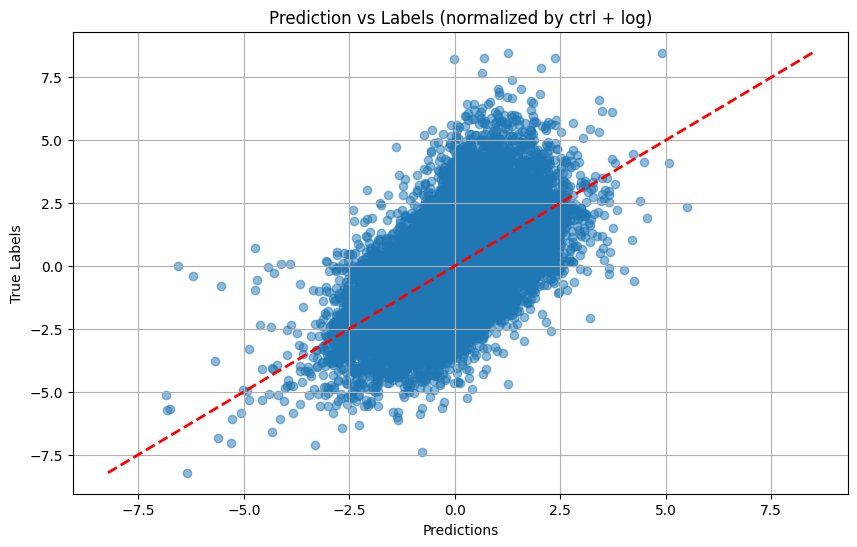

In [113]:
plot_predictions_vs_labels(predictions, labels, title='Prediction vs Labels (normalized by ctrl + log)')


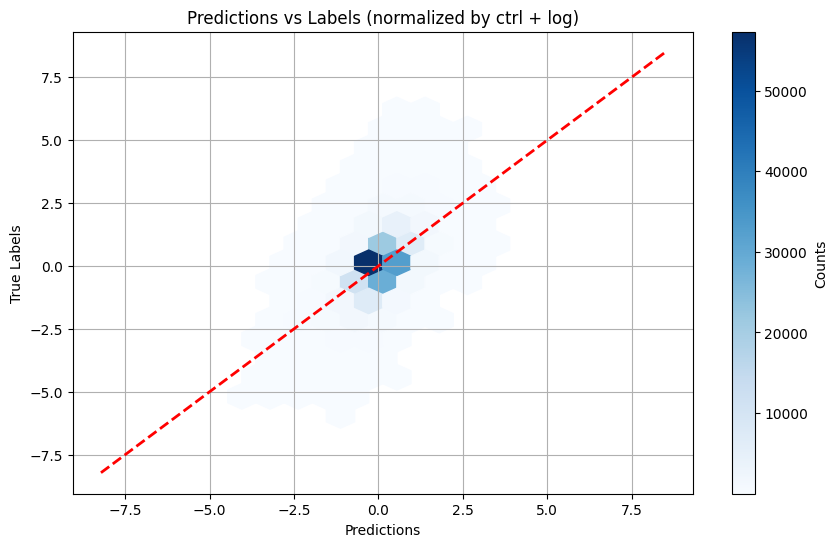

In [118]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (normalized by ctrl + log)", gridsize=20, mincnt=5)

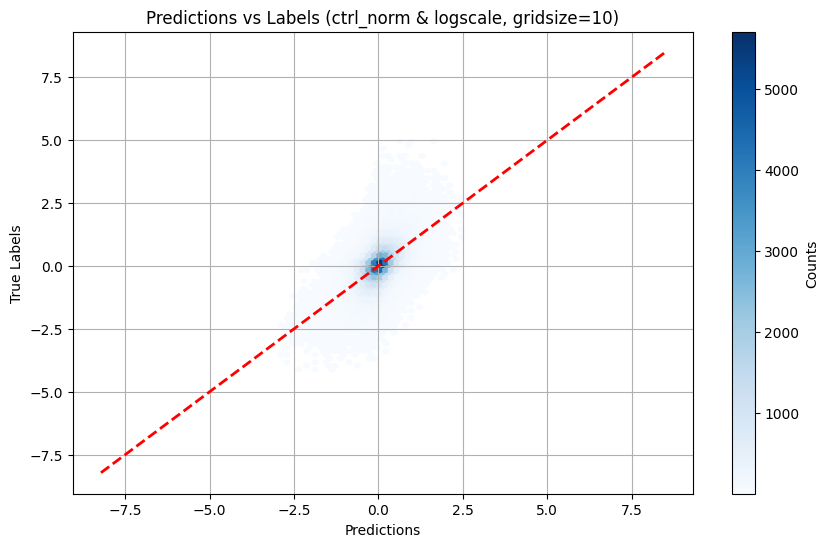

In [117]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (ctrl_norm & logscale, gridsize=10)", gridsize=100, mincnt=5)

In [172]:
species_ids

array([ 6., 21.,  7., ..., 27.,  4., 27.], dtype=float32)

In [173]:
labels

array([[ 0.5915866 ],
       [ 0.38092545],
       [-0.9554694 ],
       ...,
       [-0.8273852 ],
       [ 0.34627482],
       [ 0.3612904 ]], dtype=float32)

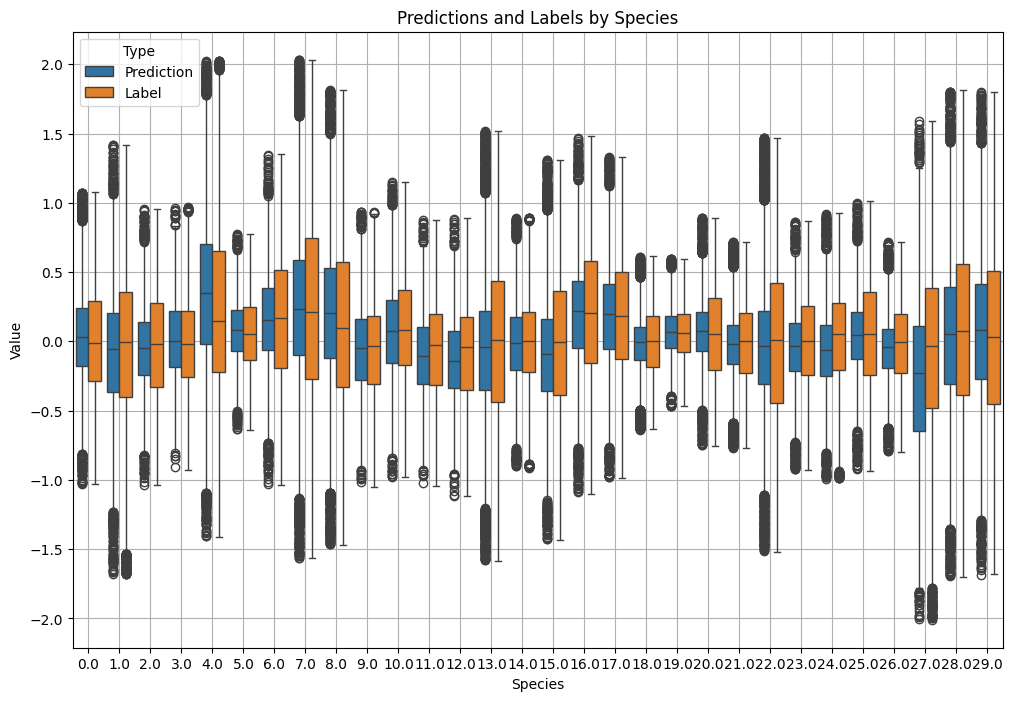

In [175]:
plot_boxplot_predictions_vs_labels(predictions.flatten(), labels.flatten(), species_ids, by_label='Species')

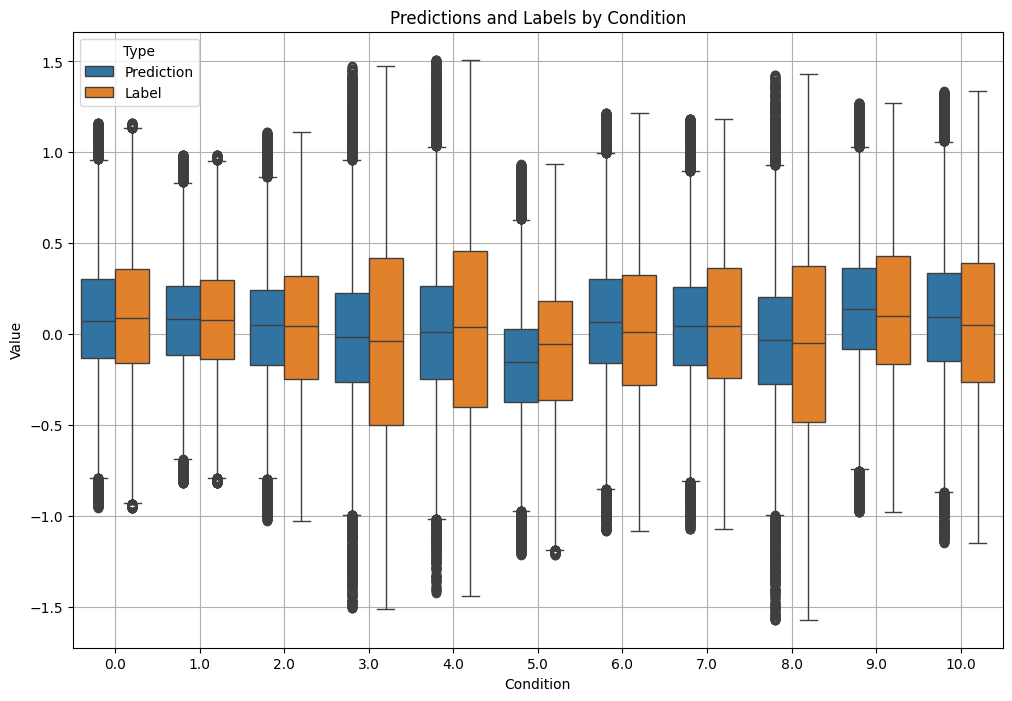

In [176]:
plot_boxplot_predictions_vs_labels(predictions.flatten(), labels.flatten(), stress_ids, by_label='Condition')

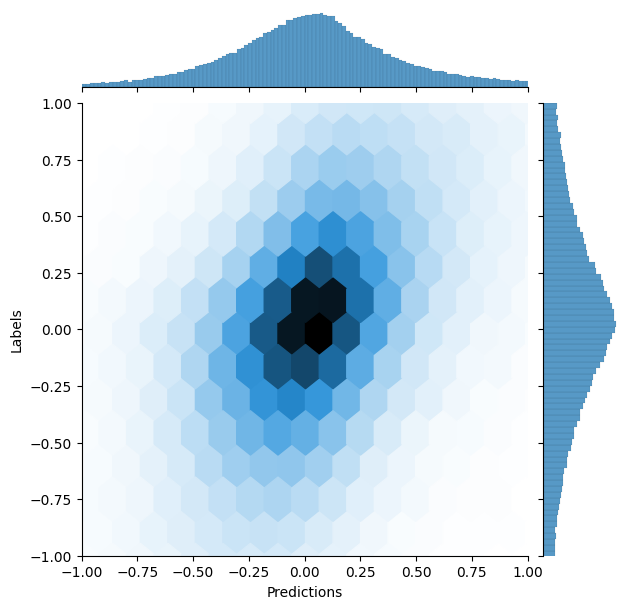

In [123]:
import seaborn as sns
g = sns.jointplot(x=predictions.flatten(), y=labels.flatten(), kind="hex", gridsize=100)
g.ax_joint.set_xlim(-1, 1)
g.ax_joint.set_ylim(-1, 1)
g.set_axis_labels('Predictions', 'Labels')

# Show the plot
plt.show()



In [9]:


X = df_dataset.drop(columns='tpm')
y = df_dataset['tpm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(f"mse: {mse:.4f}")
print(f"r2: {r2:.4f}")


mse: 0.6613
r2: 0.1494


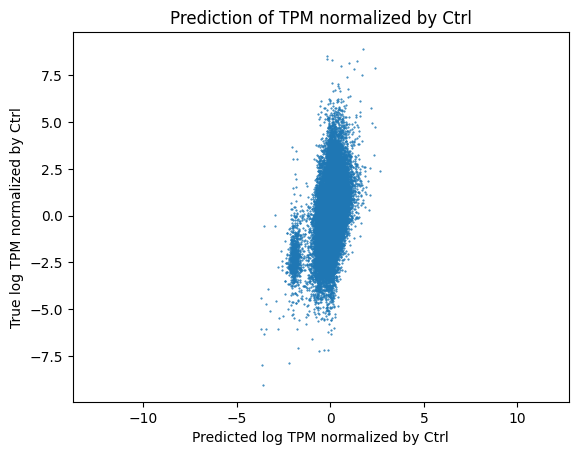

In [10]:
import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, 'o', markersize=.5)
plt.xlabel('Predicted log TPM normalized by Ctrl')
plt.ylabel('True log TPM normalized by Ctrl')
plt.title("Prediction of TPM normalized by Ctrl")
plt.axis('equal');


(-1.0, 1.0)

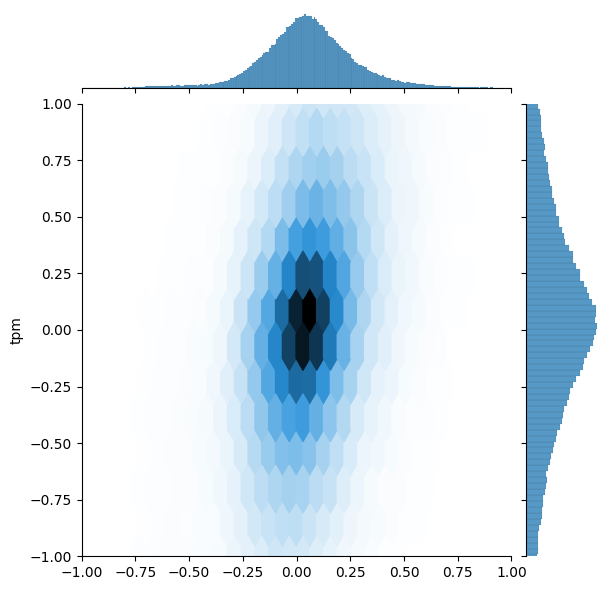

In [11]:
import seaborn as sns
sns.jointplot(x=y_pred, y=y_test, kind="hex", gridsize=100)
plt.xlim(-1, 1)
plt.ylim(-1, 1)